In [37]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import numpy as np
import xarray as xr
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import cartopy as cart

from glob import glob
from datetime import timedelta as delta
from datetime import datetime

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import plot

In [54]:
reload(plot)

<module 'plot' from '/home/students/4302001/arctic-connectivity/EEZ/plot.py'>

In [39]:
# Specify paths to velocity field and mesh
#readdir = '/Users/daanreijnders/Datasets/'
readdir = '/scratch/DaanR/fields/'

writedir = ''
field_file = 'daily_CESM_0.1degree_controlrun_year_300_arctic_region_timed.nc'
mesh = 'POP_grid_lat1800plus.nc'

In [42]:
def read_velocity_field(ufiles):
    filenames = {'U': {'lon': readdir+mesh,
                       'lat': readdir+mesh,
                       'data':ufiles},
                 'V': {'lon': readdir+mesh,
                       'lat': readdir+mesh,
                       'data':ufiles}}

    variables = {'U': 'UVEL_5m',
                 'V': 'VVEL_5m'}

    dimensions = {'U': {'time': 'time',
                        'lat': 'U_LAT_2D',
                        'lon': 'U_LON_2D'},
                  'V': {'time': 'time',
                        'lat': 'U_LAT_2D',
                        'lon': 'U_LON_2D'}}
    fieldset = FieldSet.from_pop(filenames, variables, dimensions, allow_time_extrapolation=False)
    fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
    fieldset.V.vmax = 10; fieldset.V.vmin = -10;
    return fieldset

fieldset = read_velocity_field(readdir+field_file)  

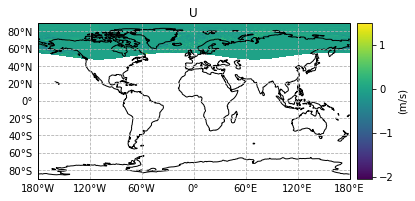

In [5]:
plot.show(fieldset.U, land=False)

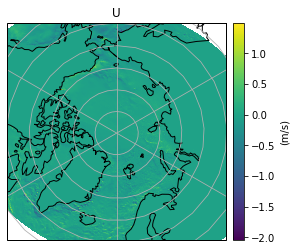

In [7]:
plot.show(fieldset.U, latrange=(60,90), land=False, polar=True)

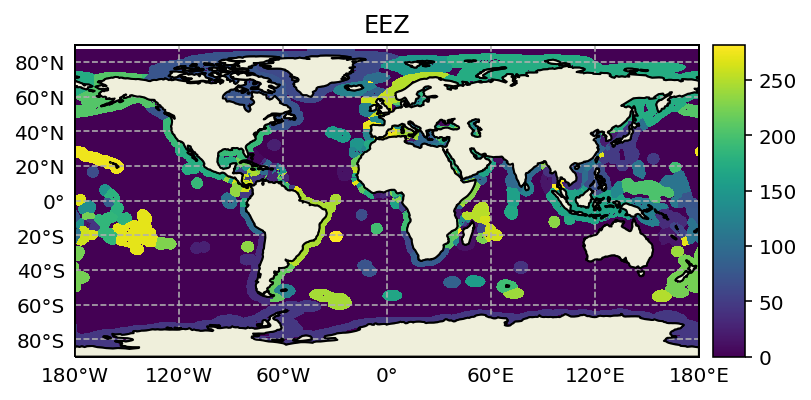

In [48]:
# Load and add EEZ field
EEZ_ds = xr.open_dataset('EEZ_export.nc')
EEZ = EEZ_ds['EEZ'][:,:]
EEZ_lats = EEZ_ds['latitude'].data
EEZ_lons = EEZ_ds['longitude'].data

EEZ_field = Field(name="EEZ", data=EEZ.data[0], mesh='spherical', lon=EEZ_lons, lat=EEZ_lats, allow_time_extrapolation=True)
fieldset.add_field(EEZ_field)

plot.show(fieldset.EEZ)

In [46]:
# Kernels and particle classes
class myParticle(JITParticle):
        EEZ = Variable('EEZ', dtype=np.int32, to_write=True)

def EEZ_sampler(particle, fieldset, time):
    particle.EEZ = fieldset.EEZ[time, 0., particle.lat, particle.lon]
        
def wrapLon(particle, fieldset, time):
    if particle.lon > 180.:
        particle.lon = particle.lon - 360.
    if particle.lon < -180.:
        particle.lon = particle.lon + 360.

def deleteParticle(particle, fieldset, time):
    particle.delete()

In [44]:
# Particle execution function
def execute_particles(fieldset, \
                      experiment_name='', \
                      npart=10, \
                      runtime=delta(days=200), \
                      dt = delta(minutes=5), \
                      outputdt = delta(hours = 6), \
                      start=(3,75), \
                      finish=(4,76), \
                      show_pset=False):
    if start[0] > 180 or finish[0] > 180:
        raise ValueError("Longitude bounds must be within range (-180,180)")
        
    startLons = np.ones(npart) * start[0]
    startLats = np.ones(npart) * start[1]
    startTime = np.array([datetime(2000, 1, 1) + delta(days = i) for i in range(npart)]) 
    pset = ParticleSet.from_list(fieldset=fieldset, pclass=myParticle, lon=startLons.tolist(), lat=startLats.tolist(), \
                       time = startTime)
    if show_pset:
        edge = 5 # Degrees around initial distribution
        pset.show()

    kernels = pset.Kernel(AdvectionRK4) + EEZ_sampler + wrapLon
    pfile = pset.ParticleFile(name = writedir+experiment_name+"_particles", outputdt=outputdt)
    print(f"Run: Advecting {npart} particles for {runtime}")

    pset.execute(kernels, \
                 runtime = runtime, \
                 dt = dt, \
                 output_file = pfile, \
                 recovery = {ErrorCode.ErrorOutOfBounds: deleteParticle})
    return pset

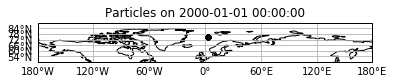

Run: Advecting 1000 particles for 200 days, 0:00:00


INFO: Compiled myParticleAdvectionRK4EEZ_samplerwrapLon ==> /var/folders/k_/m82s7xk97dlgd2rcy0bn6v100000gn/T/parcels-501/3f205158d98c92b3c6c8f355209c75e6.so
100% (17280000.0 of 17280000.0) |########| Elapsed Time: 0:05:38 Time:  0:05:38


In [46]:
pset_loc1 = execute_particles(fieldset, experiment_name='pset_EEZ_loc1', start=(3,75), finish=(4,76), show_pset=True, npart = 1000)

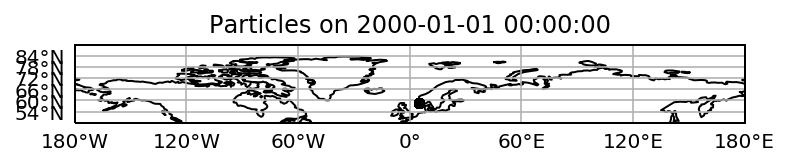

Run: Advecting 1000 particles for 200 days, 0:00:00


INFO: Compiled myParticleAdvectionRK4EEZ_samplerwrapLon ==> /tmp/parcels-23300/1b7e4a823453a83a64f834f9df96f9a1.so
100% (17280000.0 of 17280000.0) |########| Elapsed Time: 0:04:39 Time:  0:04:39


In [49]:
pset_loc2 = execute_particles(fieldset, experiment_name='pset_EEZ_loc2', start=(5.15,58.85), finish=(4,76), show_pset=True, npart = 1000)

/Users/daanreijnders/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/numpy/lib/arraysetops.py:285: FutureWarning: In the future, NAT != NAT will be True rather than False.
  mask[1:] = aux[1:] != aux[:-1]


Start and end plottimes: 2000-01-01T00:00:00.000000000 2000-07-19T00:00:00.000000000


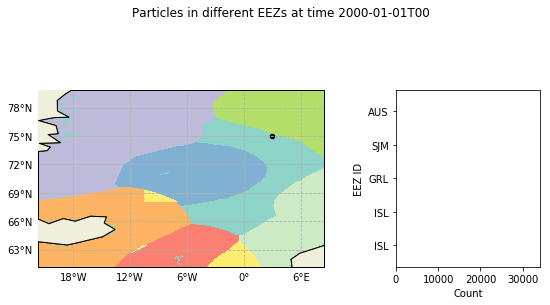

CPU times: user 11min 40s, sys: 20.9 s, total: 12min 1s
Wall time: 12min 35s


In [100]:
%%time
# Investigate data. Which EEZs are visited?
pfile_loc1 = xr.open_dataset('pset_EEZ_loc1_particles.nc', decode_cf=True)
pfile_loc2 = xr.open_dataset('pset_EEZ_loc2_particles.nc', decode_cf=True)

plot.particleAnimation.create(pfile_loc1, fieldset.EEZ, nbar=6, titleAttribute='MidNorth')
plot.particleAnimation.create(pfile_loc1, fieldset.U, titleAttribute='NorwayBay')

In [61]:
fieldset.EEZ.data[:,:].shape

(1, 1726, 3600)